In [1]:
import librosa
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt   
import IPython.display as ipd
from tqdm import tqdm

In [14]:
input,_ = librosa.load("input_1_1013.wav",sr=8000,mono=False)
input,_ = librosa.load("-90_0_90_lidar.wav",sr=16000,mono=False)
estim,_ = librosa.load("estim_1_1013.wav",sr=8000,mono=False)
print(input.shape)
print(estim.shape)

estim = estim/np.max(np.abs(estim))

(4, 140032)
(7, 74880)


Text(0.5, 1.0, 'estim')

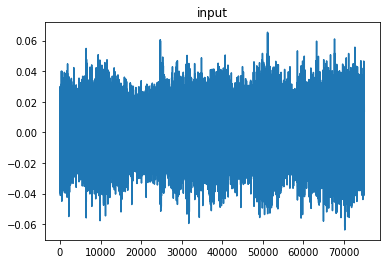

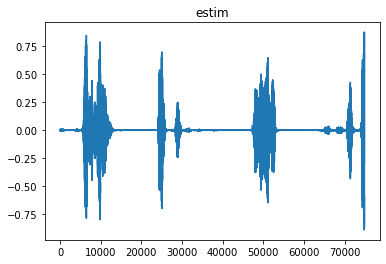

In [3]:
plt.figure()
plt.plot(input[0,:])
plt.title("input")
plt.figure()
plt.plot(estim[0,:])
plt.title("estim")

In [23]:
X = librosa.stft(input[:7,:],n_fft=512)
print(X.shape)

(4, 257, 1095)


```MATLAB

l_source =[dist*cos(deg2rad(90-azimuth)),dist*sin(deg2rad(90-azimuth)),0];

%% Calculate TDOA vector
TDOA = zeros(ch,1);
for i_ch = 1:ch
    TDOA(i_ch) = pdist([mic(i_ch,:);l_source ])/ss;
end

%% Estimate RIR
h = zeros(ch,nhfft);
for i_ch = 1:ch
    for i_nhfft=1:nhfft
      h(i_ch,i_nhfft) = exp(-1i*2*pi*(i_nhfft-1)*(TDOA(i_ch)-TDOA(1))*fs/nfft);  
    end
end

%% MVDR weight
w = zeros(ch,nhfft);

%% Rx
Rx = zeros(ch,ch,nhfft);
invRx = zeros(ch,ch,nhfft);

for i_nhfft=1:nhfft
    invRx(:,:,i_nhfft) = eye(ch,ch)*(1/ch);
end

gamma = 0.999;
gamma = 1/gamma;

%% medium
numer=zeros(ch,nhfft);
denom=zeros(nhfft,1);

%% Routine
for i_idx = 1:nFrame
    %% STFT
    x_shift = raw((i_idx-1)*shift + 1:i_idx*shift,:);
    
    % shift & copy
    for t_idx2 = shift+1:frame
        x_frame(t_idx2-shift,:) = x_frame(t_idx2,:);
    end
    x_frame(nover+1:frame,:) = x_shift;
    
    % window & half fft
    for i_ch = 1 : ch
        X_tmp(i_ch,:) = fft(x_frame(:,i_ch).*window);
        X_buffer(i_ch,:,i_idx) = X_tmp(i_ch,1:nhfft).';
    end
    
    %% RLS
    
    for i_nhfft = 1:nhfft
        invRx(:,:,i_nhfft)                                                                     ...
          = (gamma*invRx(:,:,i_nhfft) )                                                          ...
            -(((gamma^2)*invRx(:,:,i_nhfft)*X_tmp(:,i_nhfft)*X_tmp(:,i_nhfft)'*invRx(:,:,i_nhfft))...
             /                                                                                 ...
             (1 + gamma*X_tmp(:,i_nhfft)'*invRx(:,:,i_nhfft)*X_tmp(:,i_nhfft))); 
    end
    
    %% MPDR
    
    for i_nhfft = 1:nhfft
        numer(:,i_nhfft)   = invRx(:,:,i_nhfft)*h(:,i_nhfft);
        denom(i_nhfft) = h(:,i_nhfft)'*invRx(:,:,i_nhfft)*h(:,i_nhfft);
        w(:,i_nhfft) = numer(:,i_nhfft)/denom(i_nhfft);
    end
    
    for i_nhfft=1:nhfft
        X(1,i_nhfft) = w(:,i_nhfft)'*X_buffer(:,i_nhfft,i_idx);
    end
```

## Parmas

In [37]:
n_fft = 512
n_hfft = int(n_fft/2+1)
n_direction = 4
n_channel = 4
sound_speed = 340.3
sr=16000
dist = 1.0

In [40]:
# 4ch map
## Sensor map
map_sensor = np.zeros((4,3))
map_sensor[1,:]=[-0.04,-0.04,0.0]
map_sensor[0,:]=[-0.04,0.04,0.0]
map_sensor[2,:]=[0.04,-0.04,0.0]
map_sensor[3,:]=[0.04,0.04,0.0]

In [39]:
map_sensor = np.zeros((7,3));
for i in range(2,7) : 
    map_sensor[i,:] = [np.sin(i*np.pi/3),np.cos(i*np.pi/3),0]
map_sensor *= 0.043
print(map_sensor)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 3.72390924e-02 -2.15000000e-02  0.00000000e+00]
 [ 5.26598124e-18 -4.30000000e-02  0.00000000e+00]
 [-3.72390924e-02 -2.15000000e-02  0.00000000e+00]
 [-3.72390924e-02  2.15000000e-02  0.00000000e+00]
 [-1.05319625e-17  4.30000000e-02  0.00000000e+00]]


In [46]:
list_azim = np.zeros(n_direction)
for i in range(n_direction):
    list_azim[i] = i*(360/n_direction)


map_source = np.zeros((n_direction,3))
for i in range(n_direction):
    map_source[i,:] = [ dist*np.cos(np.deg2rad(90-list_azim[i]))*np.sin(np.deg2rad(45)),dist*np.sin(np.deg2rad(90-list_azim[i]))*np.sin(np.deg2rad(45)),np.cos(np.deg2rad(45)) ]    
#print(map_source)

## SV

In [47]:
# Calculate TDOA vector
TDOA = np.zeros((n_direction, n_channel));
for i in range(n_direction):
    for j in range(n_channel):
        pdist = np.linalg.norm(map_sensor[j,:] - map_source[i])
        TDOA[i,j] = pdist/sound_speed;

w = np.zeros((n_direction,n_channel,n_hfft),np.cfloat);
for i_dir in range(n_direction) :
    for i in range(n_hfft):
        for j in range(n_channel) :  
            w[i_dir,j,i] = np.exp(-1j*2*np.pi*i*(TDOA[i_dir,j]-TDOA[i_dir,0])/n_fft*sr); 
w = w/n_channel; 

## Init

# DS

In [48]:
#  Routine
Y = np.zeros((n_direction,X.shape[1],X.shape[2]),np.cfloat)
for i_dir in range(n_direction) : 
    for i in tqdm(range(X.shape[2])) : 
        for j in range(n_hfft) : 
            Y[i_dir,j,i]=np.matmul(np.asmatrix(w[i_dir,:,j:j+1]).H,X[:,j:j+1,i]);

100%|███████████████████████████████████████████████████████| 1095/1095 [00:03<00:00, 276.32it/s]


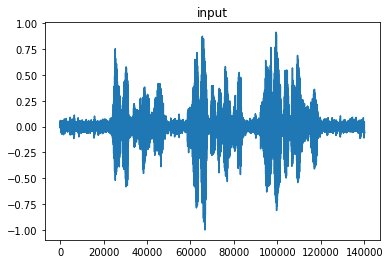

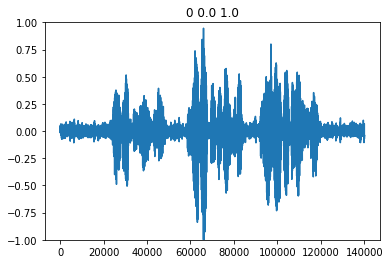

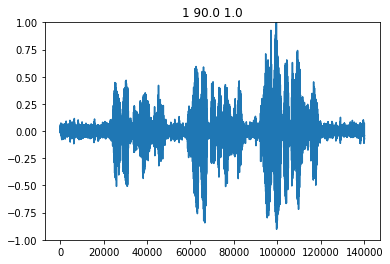

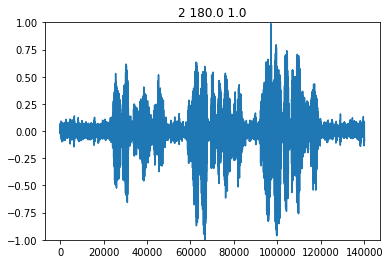

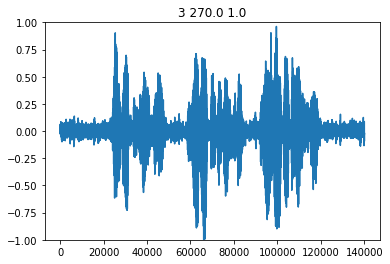

In [50]:
import soundfile as sf
plt.figure()
y = input[0,:]
y = y/np.max(np.abs(y))
plt.plot(y)

plt.title("input")
for i_dir in range(n_direction) : 
    y = librosa.istft(Y[i_dir,:,:],n_fft=512)
    y = y/np.max(np.abs(y))
    plt.figure()
    #plt.ylim([-0.025,0.025])
    plt.ylim([-1,1])
    plt.title("{} {} {}".format(i_dir,list_azim[i_dir],np.max(np.abs(y))))
    plt.plot(y)
    
    sf.write("{}.wav".format(i_dir),y,sr)

In [45]:
print(( np.asmatrix(h[i_dir,:,j:j+1]).H).shape)
print((np.matmul(invRx[i_dir,:,:,j],h[i_dir,:,j:j+1])).shape)

print((np.asmatrix(h[i_dir,:,j:j+1]).H*np.matmul(invRx[i_dir,:,:,j],h[i_dir,:,j:j+1])).shape)
print(X.shape)
print((np.asmatrix(w[:,j]).H*X[:,j,i]).shape)

NameError: name 'h' is not defined